In [1]:
from collections import Counter
import itertools
from itertools import zip_longest
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import nltk
from nltk.corpus import stopwords
import numpy as np
from numpy.linalg import norm
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.sparse import linalg 
from scipy.sparse import dok_matrix
from scipy.sparse import csr_array
from scipy.sparse import find
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity


df = pd.read_csv('../input/abcnews-date-text.csv')



nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
df['tokenized'] = df.headline_text.str.split(' ')

df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

df=df.sample(frac=0.0001)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#tokenize and sanitize

ex = df.explode('tokenized')

ex = ex.loc[ex.tokenized.str.len() > 2]

ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [3]:
#ceate dictionary of words

dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

words = dictionary.tolist()

dictionary = pd.Series(words, name='words')

dictionary = dictionary.to_frame()

dictionary_lookup = dictionary.to_dict()['words']

dictionary['encode'] = dictionary.index + 1

dictionary = dictionary.set_index('words')

dictionary.encode = dictionary.encode
dictionary = dictionary.to_dict()['encode']


In [4]:
#reduced grouping to series and aggregated to tuple
#improved from 30s to 20s

encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
docs = encode.tokenized.groupby(level=0).agg(tuple)


In [5]:

#zero pad x dimention by longest sentence
encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()

doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()

doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

doc_word.word = doc_word.word - 1

#convert to index of word counts per document
doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

#convert to sparse matrix
sparse_doc_word_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float)


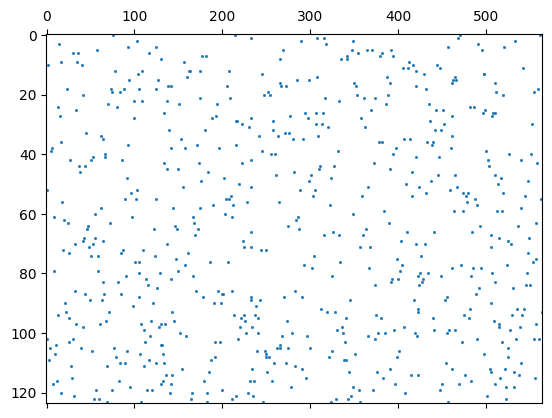

In [6]:
#visualize sparse matrix
# 1.06 TiB for an array with shape (1242915, 116795)

#fig = figure(figsize=[15, 15])
#sparse_doc_word_matrix_visualization = fig.add_subplot(1,1,1)
#sparse_doc_word_matrix_visualization.spy(sparse_doc_word_matrix, markersize=0.0016, aspect = 'auto')


fig = figure()
sparse_doc_word_matrix_visualization = fig.add_subplot(1,1,1)

sparse_doc_word_matrix_visualization.spy(sparse_doc_word_matrix, markersize=1, aspect = 'auto')



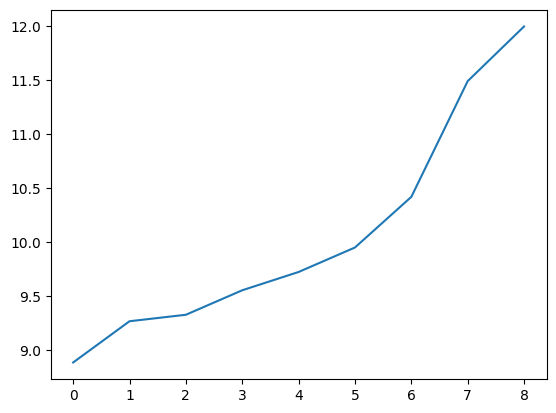

In [7]:
#U S VT
#U & VT representations of isometric transformations of the space
#S/Σ scaling of each xi by factor σi

#try coherence scores  
#or perplexity scores

documents, concepts, terms = svds(sparse_doc_word_matrix, k=9)

fig = figure()
singular_values = fig.add_subplot(1,1,1)

#concepts = np.diag(concepts)

#Singular values at log scale
#singular_values.set_yscale('log')
singular_values.plot((np.power(concepts,2)))



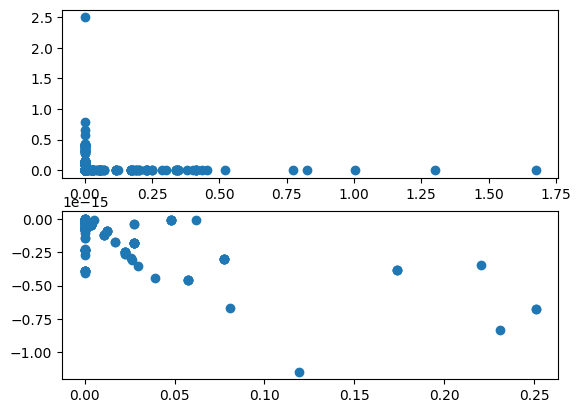

In [163]:

k=2
#words as k-vectors
#terms[allwords x 2-vectors] dot diagonal matrix of first two sigma values
terms_s = terms[-k:, :].T @ np.diag(concepts[-k:])

word_vectors_2d = pd.DataFrame(terms_s, index=words, columns=['x','y'])

negy_word_vectors_2d = word_vectors_2d.loc[word_vectors_2d.y <= 0]

posy_word_vectors_2d = word_vectors_2d.loc[word_vectors_2d.y >= 0]

fig = figure()
words_plot = fig.add_subplot(2,1,1)

words_plot.scatter(posy_word_vectors_2d['x'],posy_word_vectors_2d['y'])

words_plot = fig.add_subplot(2,1,2)

words_plot.scatter(negy_word_vectors_2d['x'],negy_word_vectors_2d['y'])

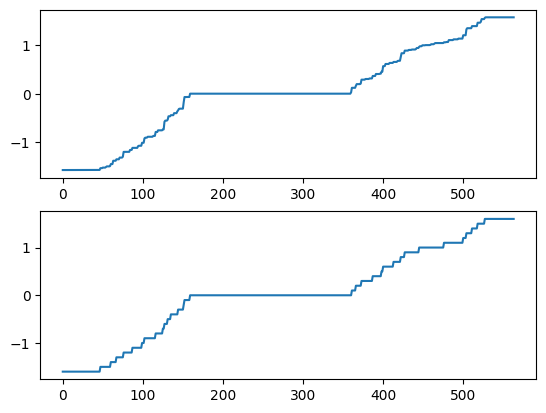

In [164]:


word_vectors_2d['magnitude'] = word_vectors_2d['x'].pow(2)+word_vectors_2d['y'].pow(2)

word_vectors_2d['angle'] = np.arctan(word_vectors_2d['y']/word_vectors_2d['x'])

angles = word_vectors_2d.angle.to_numpy()

angles = angles[angles.argsort()]

#rounding up made some of the groupings more pandas friendly
word_vectors_2d.angle = word_vectors_2d.angle.round(1)

r_angles = word_vectors_2d.angle.to_numpy()

r_angles = r_angles[r_angles.argsort()]

word_vectors_2d['angle_topics'] = word_vectors_2d.groupby('angle').ngroup()

#word_vectors_2d.angle.sort_values().to_frame().reset_index(names=['latent_topics']).groupby('angle').agg(tuple)



fig = figure()
angle_values = fig.add_subplot(2,1,1)
angle_values.plot(angles)

angle_values = fig.add_subplot(2,1,2)
angle_values.plot(r_angles)

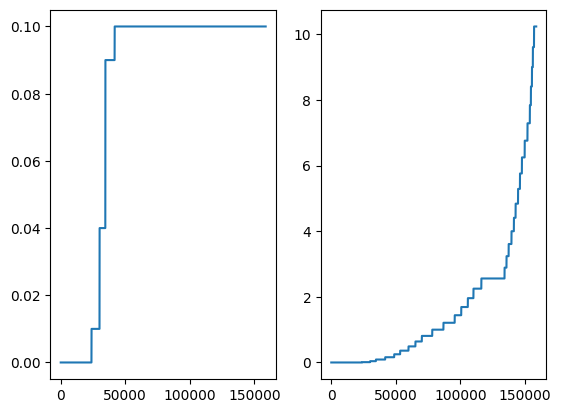

In [171]:
angles = word_vectors_2d.angle.to_numpy()

angles = angles[angles.argsort()]

angles_dif_matrix = np.reshape(angles, (len(angles), 1))
angles_dif_matrix = angles_dif_matrix - angles_dif_matrix.transpose()

preclip_angles_dif_matrix = np.square(angles_dif_matrix)

angles_dif_matrix = np.clip(preclip_angles_dif_matrix,0,0.1)

preclip_condensed_angles = squareform(preclip_angles_dif_matrix)

condensed_angles = squareform(angles_dif_matrix)

fig = figure()
condensed_angles_visualization = fig.add_subplot(1,2,1)

condensed_angles_visualization.plot(condensed_angles[np.argsort(condensed_angles)])

condensed_angles_visualization = fig.add_subplot(1,2,2)

condensed_angles_visualization.plot(preclip_condensed_angles[np.argsort(preclip_condensed_angles)])


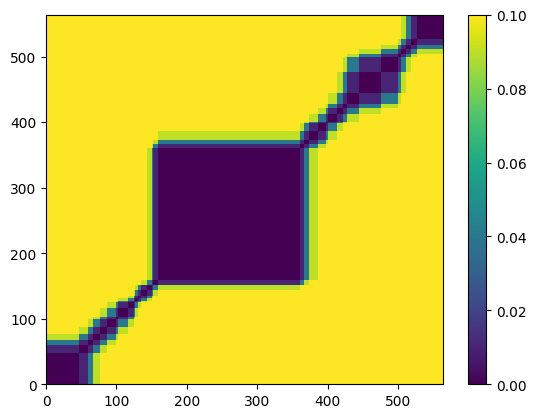

In [172]:

fig = figure()
angles_visualization = fig.add_subplot(1,1,1)
apc = angles_visualization.pcolormesh(angles_dif_matrix)
fig.colorbar(apc)

In [91]:

word_vectors_2d.x = word_vectors_2d.x.round(15)

#word_vectors_2d.x[word_vectors_2d.x == 0] = -(10^300)

word_vectors_2d.x.sort_values().to_frame().reset_index(names=['latent_topics']).groupby('x').agg(tuple)


,latent_topics
x,
-8.000000e-15,"(new,)"
-3.000000e-15,"(sydney,)"
-2.000000e-15,"(security, focus, trams, get, old, makeover, c..."
-1.000000e-15,"(blacksmith, alive, brings, ceo, keeps, bussel..."
1.000000e-15,"(water, joy, authority, baluch, toxic, one, un..."
5.000000e-04,"(returns, grows, revolt, may)"
7.000000e-04,"(ofarrell, plays, downgrade, treasury)"
9.000000e-04,"(coronavirus, border, surge, victorian, shut, ..."
3.000000e-03,"(eases, china, urges, flood, newmans, underwat..."


In [99]:
word_vectors_2d.y = word_vectors_2d.y.round(15).sort_values().to_frame().reset_index(names=['latent_topics']).groupby('y').grouper.k

,latent_topics
y,
-1.000000e-15,"(court, told, could, says, ban)"
0.000000e+00,"(ronaldo, closer, freedoms, ground, expenses, ..."
1.000000e-15,"(alarming, dead, identified, house, dalby, wor..."
2.000000e-15,"(feud, arrested, kelmscott, charged, turns, wo..."
3.000000e-15,"(police, fatal)"
5.000000e-15,"(man,)"
1.224216e-03,"(providers, ndis, care, cancelling)"
2.446955e-03,"(businesses, deregistration)"
4.895388e-03,"(face,)"


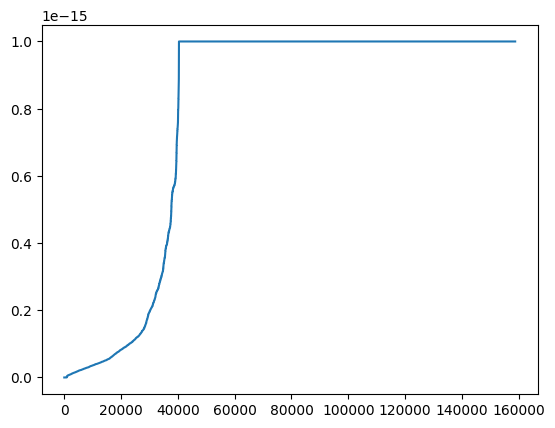

In [12]:

spacial = word_vectors_2d[['x', 'y']].to_numpy()
spacial_distance_matrix = np.clip(pdist(spacial),0,0.000000000000001)
fig = figure()
distances = fig.add_subplot(1,1,1)

#Cumulative singular values
distances.plot(spacial_distance_matrix[np.argsort(spacial_distance_matrix)])

In [ ]:

fig = figure()
distances = fig.add_subplot(1,1,1)

#Cumulative singular values
distances.plot(spacial_distance_matrix[np.argsort(spacial_distance_matrix)])

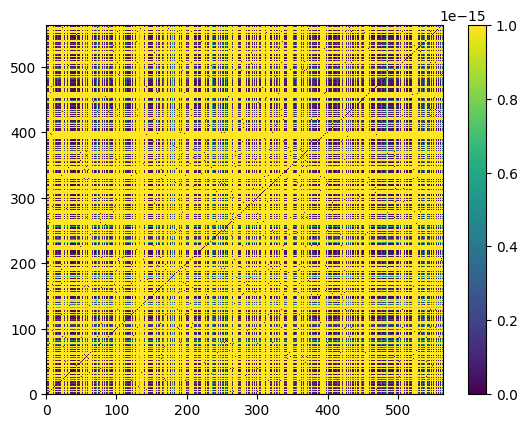

In [13]:
spacial_distance_matrix = squareform(spacial_distance_matrix)

fig = figure()
distance_visualization = fig.add_subplot(1,1,1)
pc = distance_visualization.pcolormesh(spacial_distance_matrix)
fig.colorbar(pc)

In [32]:
top_words = pd.DataFrame(np.array(find(spacial_distance_matrix)).T, columns=['latent_topics','y','distance'])

top_words.latent_topics = top_words.latent_topics.map(dictionary_lookup.get)

top_words.y = top_words.y.map(dictionary_lookup.get)

top_words = top_words.append(top_words[['y','latent_topics','distance']]).drop_duplicates(['distance','latent_topics'])

top_words[['distance','latent_topics']].groupby('distance').agg(tuple)



/tmp/ipykernel_738959/2475596969.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_words = top_words.append(top_words[['y','latent_topics','distance']]).drop_duplicates(['distance','latent_topics'])


,latent_topics
distance,
3.342243e-31,"(landfall, ike, texas)"
1.860282e-19,"(hall, medal, wins, eales, latham, john)"
7.007575e-19,"(royalty, federer, news, pm1, front, closer, i..."
7.743135e-19,"(close, royalty, federer, depor, front, real, ..."
8.396208e-19,"(close, news, depor, pm1, closer, real)"
...,...
9.345983e-16,"(markets, cup)"
9.459171e-16,"(cup, accused, bail, sex, granted)"
9.493008e-16,"(kavalee, var, world, penalty, decisions)"
